# Linear Model with AIC feature engineering

The linear method makes use of the log backward return (log price difference) to predict foward return.

Training:
1) Ridge regression: on 30 features
2) PC regression: pca on 30 features then perform ols

Feature: 10 stocks, each with 3 backward return (say, 3min, 7min, 10min, see correlation to decide)

Response: 10 stocks' 30min forward return. 

## Data Preparation

In [1]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

log_pr = pd.read_pickle("../data/log_price.df")
volu = pd.read_pickle("../data/volume_usd.df")

In [189]:
# Data Preparation
def logr(dta,min):
    '''
    Input
    dta: pandas dataframe nxp
    min: backward length
    Return
    log return: pandas dataframe
    '''
    return dta.diff(min,0).dropna()

In [190]:
x_begin_idx = log_pr.index[30]
x_end_idx = log_pr.index[-31]
y_begin_idx = log_pr.index[60]

x = pd.concat((logr(log_pr,3)[x_begin_idx:x_end_idx],
                logr(log_pr,5)[x_begin_idx:x_end_idx],
                logr(log_pr,7)[x_begin_idx:x_end_idx]),axis=1)
y = log_pr.diff(30)[y_begin_idx:]
y = y.set_index(x.index)

xtrain,xvali,xtest = x[:log_pr.index[-87841]],x[log_pr.index[-87840]:log_pr.index[-44641]],x[log_pr.index[-44640]:]
ytrain,yvali,ytest= y[:log_pr.index[-87841]],y[log_pr.index[-87840]:log_pr.index[-44641]],y[log_pr.index[-44640]:]

In [ ]:
def evaluate(log_pr_test, volu_test):
    t0 = time.time()
    dt = datetime.timedelta(days=1)

    r_fwd = (log_pr_test.shift(-30) - log_pr_test).iloc[1440::10]
    r_hat = pd.DataFrame(index=log_pr_test.index[1440::10], columns=np.arange(10), dtype=np.float64)

    for t in log_pr_test.index[1440::10]: # compute the predictions every 10 minutes
        # inputs 1 day of log price and volume
        r_hat.loc[t, :] = get_r_hat(log_pr_test.loc[(t - dt):t], volu_test.loc[(t - dt):t])
    t_used = time.time() - t0
    print("Time used: ", t_used)

    r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final 3 rows are NaNs. 
    r_hat_all = r_hat.iloc[:-3].values.ravel()
    return np.corrcoef(r_fwd_all, r_hat_all)[0,1]

## Ridge Regression

### Model Fitting & Validation

In [240]:
# Model Fitting
from sklearn.linear_model import Ridge
rr = Ridge(alpha=5).fit(xtrain,ytrain)
# 10-minute-rolling 30-min log-return prediction for validation set
yvali_hat_ridge = pd.DataFrame(rr.predict(xvali),columns={i for i in range(10)},index=yvali.index)
# compute pairwise correlation
#print(yvali_hat_ridge.corrwith(yvali[::10]))
print(np.corrcoef(yvali_hat_ridge[::10],yvali[::10])[0,1])
# Compute mse
#from sklearn.metrics import mean_squared_error
#mean_squared_error(yvali,yvali_hat_ridge)

0.07373440706806567


### Grid Search $\alpha$

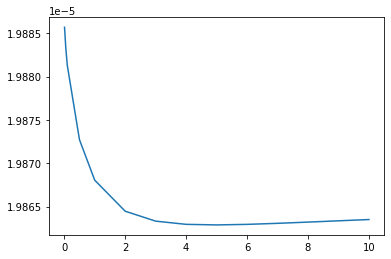

In [239]:
from sklearn.metrics import mean_squared_error
alpha_grid = np.array([0.01,0.05,0.1,0.5,1,2,3,4,5,6,7,8,9,10])
mse = np.empty(alpha_grid.shape[0])
for i in range(alpha_grid.shape[0]):
    rr_a = Ridge(alpha=alpha_grid[i]).fit(xtrain,ytrain)
    yvali_hat_ridge_a = pd.DataFrame(rr_a.predict(xvali),columns={i for i in range(10)},index=yvali.index)
    mse[i] = mean_squared_error(yvali,yvali_hat_ridge_a)
plt.plot(alpha_grid,mse)

### Ridge Test Evaluation

In [245]:
rr = Ridge(alpha=5).fit(pd.concat((xtrain,xvali)),pd.concat((ytrain,yvali)))

def get_r_hat(A, B): 
    x = pd.concat((A.diff(3,0).iloc[-1],A.diff(5,0).iloc[-1],A.diff(7,0).iloc[-1]))
    x = pd.DataFrame(x).transpose()
    return rr.predict(x)

def evaluate(log_pr_test, volu_test):
    t0 = time.time()
    dt = datetime.timedelta(days=1)

    r_fwd = (log_pr_test.shift(-30) - log_pr_test).iloc[1440::10]
    r_hat = pd.DataFrame(index=log_pr_test.index[1440::10], columns=np.arange(10), dtype=np.float64)

    for t in log_pr_test.index[1440::10]: # compute the predictions every 10 minutes
        # inputs 1 day of log price and volume
        r_hat.loc[t, :] = get_r_hat(log_pr_test.loc[(t - dt):t], volu_test.loc[(t - dt):t])
    t_used = time.time() - t0
    print("Time used: ", t_used)

    r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final 3 rows are NaNs. 
    r_hat_all = r_hat.iloc[:-3].values.ravel()
    return r_fwd.corrwith(r_hat),np.corrcoef(r_fwd_all, r_hat_all)[0,1]

evaluate(log_pr[log_pr.index[-44640]:],volu[log_pr.index[-44640]:])

Time used:  16.49103331565857


(0    0.045081
 1    0.106525
 2   -0.027624
 3    0.025216
 4   -0.012093
 5    0.092038
 6    0.064001
 7   -0.021956
 8    0.045625
 9    0.093557
 dtype: float64,
 0.02676829625356025)

## PC Regression

### Model Fitting & Validation

In [213]:
# PCA transformation
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
pca = PCA()
xtrain_pc = pca.fit_transform(scale(xtrain))[:,:20]
# Model Training
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(xtrain_pc,ytrain)
# Evaluation on Validation data
xvali_pc = pca.transform(scale(xvali))[:,:20]
yvali_hat_pca = pd.DataFrame(lr.predict(xvali_pc),columns={i for i in range(10)},index=yvali.index)
yvali_hat_pca.corrwith(yvali)

0    0.011665
1    0.054788
2   -0.002117
3    0.000857
4    0.010895
5    0.022066
6    0.031792
7    0.005105
8    0.059085
9    0.038133
dtype: float64

### PCA Test Evaluation

In [214]:
def get_r_hat(A, B): 
    x = pd.concat((A.diff(3,0).iloc[-1],A.diff(5,0).iloc[-1],A.diff(7,0).iloc[-1]))
    x = pd.DataFrame(x).transpose()
    x_pc = pca.transform(x)
    return lr.predict(x_pc)

evaluate(log_pr[log_pr.index[-44640]:],volu[log_pr.index[-44640]:])

Time used:  14.433970928192139


0.015289318934865622